In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from tqdm import trange,tqdm
import os, shutil     
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init
from keras.preprocessing.image import load_img
import gc
gc.collect()
torch.cuda.empty_cache()

In [152]:
#constrains
WIDTH = 256
HEIGHT = 256
IMAGE_SIZE=(WIDTH,HEIGHT)
CHANNELS = 3



device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)


In [153]:
vgg19 = models.vgg19(pretrained = True)
vgg19.classifier = nn.Sequential(
            nn.Linear(512*8*8,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096,7)
)
vgg19.avgpool = nn.AdaptiveAvgPool2d((8,8))
vgg19.to(device)
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [154]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 16

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.SGD(vgg19.parameters(), lr=learning_rate)

trans = transforms.Compose([transforms.Resize((256,256)),
                            transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 2,gamma = 0.001)


In [155]:
from torchvision.datasets import ImageFolder 

dataset = ImageFolder(root = '../input/first-dataset/train/train',transform = trans)

train_size = 1400
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [97]:
#train_dataset.class_to_idx
labels = ['dog', 'elephant','giraffe','guitar', 'horse', 'house', 'person']

tensor([-1.0185, -3.5528, -1.9803,  6.2378, -8.4647, 18.8198, -1.0311],
       device='cuda:0', grad_fn=<SqueezeBackward0>) house


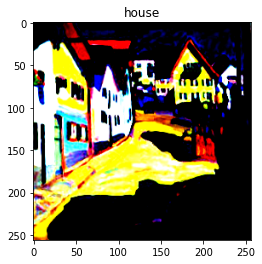

In [145]:
for batch in train_loader:
    plt.title(labels[batch[1][0].item()])
    plt.imshow(batch[0][0].permute(1,2,0))
    res = vgg19(batch[0][0].unsqueeze(0).to(device)).squeeze()
    print(res,labels[res.max(dim = 0)[1].item()] )
    break

In [ ]:
total_batch = len(train_loader)

print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    vgg19.train()
    correct = 0
    total = 0
    lr_sche.step()
    for i,(X, Y) in enumerate(train_loader):
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()        
        hypothesis = vgg19(X)
#         if epoch == 1:
#             print(f'{epoch +1}_{hypothesis[0]}')
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    with torch.no_grad():
        correct = 0
        total = 0
        for X, Y in (test_loader):
        
            X = X.to(device)
            Y = Y.to(device)
            prediction = vgg19(X)
            correct += torch.sum(torch.max(prediction,dim=1)[1] == Y).item()
            total += batch_size
        
        print("현재 정확도: ",correct/total)
   
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.


In [ ]:
torch.save(vgg19,'vgg19_sche.pt')

In [132]:
import glob
from torch.utils.data import DataLoader
from torchvision.io import read_image
class DataSet:
    
    def __init__(self, root):
        self.images = []
        self.label = 0
        file_list = glob.glob(root+'*')
        file_list.sort()
        for i in trange(len(file_list)):
            self.images.append(read_image(file_list[i]))
    def __len__(self):
    
        return len(self.images)
    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """
        img = self.images[idx]
        img = img.unsqueeze(0)
        return img.float().to(device)
    def setlabel(self,l):
        self.label = l
        


In [133]:
ds = DataSet('../input/first-dataset/test/test/0/')

100%|██████████| 350/350 [00:01<00:00, 207.50it/s]


In [141]:
result = []

with torch.no_grad():
    for i in trange (ds.__len__()):
    
        prediction = vgg19(ds.__getitem__(i)).squeeze()
        result.append(torch.argmax(prediction).item())
        ##print(prediction)

    prediction_np = np.array(result)
    print(result)
    file=pd.read_csv('../input/first-dataset/sample_submission.csv')
    file['value'] =result
    file.to_csv('result.csv', index=False)
    


100%|██████████| 350/350 [00:03<00:00, 89.38it/s]

[3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 0, 3, 3, 3, 5, 3, 3, 0, 5, 1, 3, 0, 5, 2, 5, 3, 3, 0, 5, 5, 4, 5, 3, 2, 0, 2, 3, 3, 3, 0, 5, 5, 3, 5, 5, 2, 3, 5, 0, 3, 5, 3, 3, 3, 0, 6, 3, 3, 0, 4, 3, 3, 3, 3, 3, 0, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 2, 5, 3, 5, 5, 6, 3, 3, 5, 6, 5, 3, 5, 2, 3, 2, 5, 3, 0, 3, 3, 3, 2, 5, 3, 5, 0, 3, 5, 5, 3, 2, 5, 0, 3, 3, 3, 6, 0, 3, 0, 1, 6, 4, 3, 2, 5, 3, 5, 0, 2, 3, 2, 5, 3, 5, 4, 3, 2, 5, 6, 3, 2, 3, 3, 3, 0, 3, 0, 5, 2, 2, 3, 3, 3, 1, 3, 5, 6, 2, 1, 5, 3, 3, 0, 3, 2, 5, 3, 4, 3, 0, 3, 6, 0, 3, 2, 2, 0, 4, 3, 3, 3, 2, 3, 5, 6, 2, 3, 3, 5, 3, 4, 5, 5, 3, 3, 3, 0, 5, 3, 3, 1, 3, 3, 5, 2, 2, 0, 3, 5, 1, 3, 2, 5, 3, 3, 2, 5, 2, 3, 5, 2, 3, 3, 3, 0, 5, 4, 3, 3, 3, 2, 1, 5, 0, 5, 1, 3, 3, 3, 3, 5, 3, 1, 4, 2, 3, 3, 3, 1, 0, 2, 0, 0, 4, 0, 4, 2, 3, 3, 5, 3, 4, 6, 3, 6, 4, 3, 3, 6, 3, 0, 3, 5, 3, 3, 0, 5, 2, 5, 5, 2, 5, 0, 6, 5, 3, 5, 5, 5, 3, 3, 3, 3, 1, 3, 5, 3, 3, 0, 4, 3, 3, 3, 2, 5, 3, 2, 0, 3, 3, 0, 3, 3, 3, 0, 5, 2, 2, 3, 5, 3, 